In [5]:
import pennylane as qml
import numpy as np
import jax
import matplotlib.pyplot as plt
from io import StringIO
import sys
from typing import List, Protocol, Callable, Tuple
from typing import List, Tuple, Callable


# Configure JAX
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")
jnp = jax.numpy

def create_transverse_hamiltonian(num_wires: int, J: float = 1.0, h: float = 0.5):
    coeffs = []
    obs = []

    # ZZ interactions
    for i in range(num_wires):
        for j in range(i + 1, num_wires):
            coeffs.append(-J)
            obs.append(qml.PauliZ(i) @ qml.PauliZ(j))

    # X interactions
    for i in range(num_wires):
        coeffs.append(-h)
        obs.append(qml.PauliX(i))

    hamiltonian = qml.Hamiltonian(coeffs, obs)
    e_min = min(qml.eigvals(hamiltonian))
    return hamiltonian, e_min

def create_heisenberg_hamiltonian(num_wires: int, J: float = 1.0):
    coeffs = []
    obs = []

    # Heisenberg interactions (XX + YY + ZZ)
    for i in range(num_wires):
        for j in range(i + 1, num_wires):
            coeffs.extend([-J, -J, -J])
            obs.extend([qml.PauliX(i) @ qml.PauliX(j), qml.PauliY(i) @ qml.PauliY(j), qml.PauliZ(i) @ qml.PauliZ(j)])

    hamiltonian = qml.Hamiltonian(coeffs, obs)
    e_min = min(qml.eigvals(hamiltonian))
    return hamiltonian, e_min

def create_longitudinal_ising_hamiltonian(num_wires: int, J: float = 1.0, hx: float = 0.5, hz: float = 0.5):
    coeffs = []
    obs = []

    # ZZ interactions
    for i in range(num_wires):
        for j in range(i + 1, num_wires):
            coeffs.append(-J)
            obs.append(qml.PauliZ(i) @ qml.PauliZ(j))

    # X interactions (transverse field)
    for i in range(num_wires):
        coeffs.append(-hx)
        obs.append(qml.PauliX(i))
    
    # Z interactions (longitudinal field)
    for i in range(num_wires):
        coeffs.append(-hz)
        obs.append(qml.PauliZ(i))

    hamiltonian = qml.Hamiltonian(coeffs, obs)
    e_min = min(qml.eigvals(hamiltonian))
    return hamiltonian, e_min

In [7]:

class Operation(Protocol):
    def apply(self, params: np.ndarray, wires: List[int]) -> None:
        ...

class TwoQubitDecomp:
    def apply(self, params: np.ndarray, wires: List[int]) -> None:
        """Implement an arbitrary SU(4) gate on two qubits
        using the decomposition from Theorem 5 in
        https://arxiv.org/pdf/quant-ph/0308006.pdf"""
        i, j = wires
        qml.Rot(*params[:3], wires=i)
        qml.Rot(*params[3:6], wires=j)
        qml.CNOT(wires=[j, i])
        qml.RZ(params[6], wires=i)
        qml.RY(params[7], wires=j)
        qml.CNOT(wires=[i, j])
        qml.RY(params[8], wires=j)
        qml.CNOT(wires=[j, i])
        qml.Rot(*params[9:12], wires=i)
        qml.Rot(*params[12:15], wires=j)

class PauliRotSequence:
    def apply(self, params: np.ndarray, wires: List[int]) -> None:
        qml.ArbitraryUnitary(params, wires=wires)

class SpecialUnitaryGate:
    def apply(self, params: np.ndarray, wires: List[int]) -> None:
        qml.SpecialUnitary(params, wires=wires)

# Initialize parameters
num_wires = 6
num_blocks = 2
num_layers = 2
num_params = 15
loc = 2
learning_rate = 1e-4
num_steps = 500
# init_params = jax.numpy.array(init_params)
# # Define a function that returns a default value for the innermost dictionary
# def nested_dict():
#     return defaultdict(lambda: defaultdict(lambda: [None, None]))

# Initialize the top-level defaultdict
energies = {}

dev = qml.device("default.qubit", wires=num_wires)

def circuit(params, operation: Operation, hamiltonian):
        for params_block in params:
            for i, params_layer in enumerate(params_block):
                for j, params_op in enumerate(params_layer):
                    wires_op = [w % num_wires for w in range(loc * j + i, loc * (j + 1) + i)]
                    operation.apply(params_op, wires_op)
        return qml.expval(hamiltonian)


#  circuitLauncher
def launch_circuit(hamiltonian_func: Callable[[], Tuple[qml.Hamiltonian, float]]):
    hamiltonian, e_min = hamiltonian_func()
    def circuit_wrapped(params, operation: Operation):
        return circuit(params, operation, hamiltonian)

    qnode = qml.QNode(circuit_wrapped, dev, interface="jax")
    return qnode, e_min

# def run_step(qnode, params, operation, learning_rate):
#     cost = qnode(params, operation)
#     params = params - learning_rate * jax.grad(qnode)(params, operation)
#     return params, cost

# #run the loop
# def run(operations: List[Tuple[str, Operation]], hamiltonian_funcs: List[Tuple[str, Callable[[], Tuple[qml.Hamiltonian, float]]]]):
#     energies = {}
#     for hamiltonian_name, hamiltonian_func in hamiltonian_funcs:
#         energies[hamiltonian_name] = {}
#         for operation_name, operation in operations:
#             energies[hamiltonian_name][operation_name] = {}
#             qnode, E_min = launch_circuit(hamiltonian_func)
#             for num_blocks in range(2,7,2):
#                 init_params = jax.numpy.array(np.random.randn(num_blocks, num_layers, 3, num_params))
#                 print(f"Running the optimization for the {operation_name} with {hamiltonian_name} repeats {num_blocks}, E_min {E_min}")
#                 params = init_params.copy()
#                 energy = []
#                 with concurrent.futures.ThreadPoolExecutor() as executor:
#                     future_to_step = {executor.submit(run_step, qnode, params, operation, learning_rate): step for step in range(1, num_steps + 1)}
#                     for future in concurrent.futures.as_completed(future_to_step):
#                         step = future_to_step[future]
#                         try:
#                             params, cost = future.result()
#                             energy.append(cost)
#                             if step % 50 == 0:
#                                 print(f"{step:3d} Steps: {cost:.6f}")
#                         except Exception as exc:
#                             print(f"{step:3d} generated an exception: {exc}")
#                 #energy.append(qnode(params, operation))
#                 final_energy = energy[-1]
#                 energies[hamiltonian_name][operation_name][num_blocks] = [energy, abs(final_energy), E_min]
#     return energies

# def run_block(qnode, init_params, operation, num_steps, learning_rate):
#     params = init_params.copy()
#     energy = []
#     # output = StringIO()
#     # original_stdout = sys.stdout
#     # sys.stdout = output
#     # try:
#     #     for step in range(1, num_steps + 1):
#     #         cost = qnode(params, operation)
#     #         params = params - learning_rate * jax.grad(qnode)(params, operation)
#     #         energy.append(cost)
#     #         if step % 20 == 0:
#     #             print(f"{step:3d} Steps: {cost:.6f}")
#     # finally:
#     #     sys.stdout = original_stdout
#     print("started", )
#     for step in range(1, num_steps + 1):
#         cost = qnode(params, operation)
#         params = params - learning_rate * jax.grad(qnode)(params, operation)
#         energy.append(cost)
#         print(f"{step:3d} Steps: {cost:.6f}")
#     final_energy = energy[-1]
#     return energy, abs(final_energy)

# def run(operations: List[Tuple[str, Operation]], hamiltonian_funcs: List[Tuple[str, Callable[[], Tuple[qml.Hamiltonian, float]]]]):
#     energies = {}
#     for hamiltonian_name, hamiltonian_func in hamiltonian_funcs:
#         energies[hamiltonian_name] = {}
#         for operation_name, operation in operations:
#             energies[hamiltonian_name][operation_name] = {}
#             qnode, E_min = launch_circuit(hamiltonian_func)
#             with concurrent.futures.ThreadPoolExecutor() as executor:
#                 future_to_blocks = {}
#                 for num_blocks in range(2, 7, 2):
#                     init_params = jnp.array(np.random.randn(num_blocks, num_layers, 3, num_params))
#                     print(f"Running the optimization for the {operation_name} with {hamiltonian_name} repeats {num_blocks}, E_min {E_min}")
#                     future = executor.submit(run_block, qnode, init_params, operation, num_steps, learning_rate)
#                     future_to_blocks[future] = num_blocks

#                 for future in concurrent.futures.as_completed(future_to_blocks):
#                     num_blocks = future_to_blocks[future]
#                     try:
#                         energy, final_energy = future.result()
#                         energies[hamiltonian_name][operation_name][num_blocks] = [energy, final_energy, E_min]
#                         if num_blocks % 50 == 0:
#                             print("finished step", num_blocks)
#                     except Exception as exc:
#                         raise Exception(f"{num_blocks} block  {hamiltonian_name},{operation_name} an exception: {exc}")

#     return energies

# run the loop
import pickle
import os

def save_data(hamiltonian_name, operation_name, num_blocks, energy, final_energy, E_min):
    directory = f'energies/{hamiltonian_name}/{operation_name}'
    os.makedirs(directory, exist_ok=True)
    file_path = f'{directory}/{num_blocks}.pkl'
    with open(file_path, 'wb') as f:
        pickle.dump([energy, abs(final_energy), E_min], f)

def load_data(hamiltonian_name, operation_name, num_blocks):
    file_path = f'energies/{hamiltonian_name}/{operation_name}/{num_blocks}.pkl'
    if os.path.exists(file_path):
        with open(file_path, 'rb') as f:
            return pickle.load(f)
    return None

def run(operations: List[Tuple[str, Operation]], hamiltonian_funcs: List[Tuple[str, Callable[[], Tuple[qml.Hamiltonian, float]]]]):
    energies = {}

    for hamiltonian_name, hamiltonian_func in hamiltonian_funcs:
        energies[hamiltonian_name] = {}
        for operation_name, operation in operations:
            energies[hamiltonian_name][operation_name] = {}
            qnode, E_min = launch_circuit(hamiltonian_func)
            for num_blocks in range(2, 7, 2):
                # Load data if it exists
                data = load_data(hamiltonian_name, operation_name, num_blocks)
                if data is not None:
                    energies[hamiltonian_name][operation_name][num_blocks] = data
                    continue

                init_params = jax.numpy.array(np.random.randn(num_blocks, num_layers, 3, num_params))
                print(f"Running the optimization for the {operation_name} with {hamiltonian_name} repeats {num_blocks}, E_min {E_min}")
                params = init_params.copy()
                energy = []
                for step in range(1, num_steps + 1):
                    cost = qnode(params, operation)
                    params = params - learning_rate * jax.grad(qnode)(params, operation)
                    energy.append(cost)
                    if step % 50 == 0:
                        print(f"{step} Steps: {cost:.6f}")
                final_energy = energy[-1]
                energies[hamiltonian_name][operation_name][num_blocks] = [energy, abs(final_energy), E_min]
                
                # Save data to file
                save_data(hamiltonian_name, operation_name, num_blocks, energy, final_energy, E_min)
                
    return energies
    
if __name__ == "__main__":
    # Example of running the optimization
    hamiltonian_funcs = [("ZZ Hamiltonian", lambda: create_transverse_hamiltonian(num_wires)), 
                         ("Heisenberg Hamiltonian", lambda: create_heisenberg_hamiltonian(num_wires)),
                         ("Longitudinal Ising Hamiltonian", lambda: create_longitudinal_ising_hamiltonian(num_wires))]

    
    operations = [("TwoQubitDecomp", TwoQubitDecomp()), 
                  ("PauliRotSequence", PauliRotSequence()), 
                  ("SpecialUnitaryGate", SpecialUnitaryGate())]

    energies = run(operations, hamiltonian_funcs)


Running the optimization for the TwoQubitDecomp with ZZ Hamiltonian repeats 2, E_min -15.150118797798024
50 Steps: -0.276574
100 Steps: -0.340319
150 Steps: -0.405952
200 Steps: -0.473698
250 Steps: -0.543801
300 Steps: -0.616523
350 Steps: -0.692146
400 Steps: -0.770974
450 Steps: -0.853330
500 Steps: -0.939560
Running the optimization for the TwoQubitDecomp with ZZ Hamiltonian repeats 4, E_min -15.150118797798024
50 Steps: -0.808270
100 Steps: -1.041838
150 Steps: -1.287446
200 Steps: -1.542802
250 Steps: -1.805393
300 Steps: -2.072710
350 Steps: -2.342449
400 Steps: -2.612663
450 Steps: -2.881834
500 Steps: -3.148890
Running the optimization for the TwoQubitDecomp with ZZ Hamiltonian repeats 6, E_min -15.150118797798024
50 Steps: 0.091871
100 Steps: -0.202935
150 Steps: -0.529336
200 Steps: -0.887134
250 Steps: -1.275028
300 Steps: -1.690580
350 Steps: -2.130139
400 Steps: -2.588814
450 Steps: -3.060648
500 Steps: -3.539109
Running the optimization for the PauliRotSequence with ZZ H

/opt/homebrew/anaconda3/envs/pennylane/lib/python3.12/site-packages/pennylane/ops/functions/eigvals.py:120: UserWarning: For Hamiltonians, the eigenvalues will be computed numerically. This may be computationally intensive for a large number of wires. Consider using a sparse representation of the Hamiltonian with qml.SparseHamiltonian.
  warnings.warn(
/opt/homebrew/anaconda3/envs/pennylane/lib/python3.12/site-packages/jax/_src/lax/lax.py:2740: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


50 Steps: -0.745433
100 Steps: -1.017126
150 Steps: -1.321006
200 Steps: -1.663833
250 Steps: -2.053120
300 Steps: -2.496402
350 Steps: -2.999944
400 Steps: -3.566815
450 Steps: -4.194653
500 Steps: -4.873837
Running the optimization for the SpecialUnitaryGate with ZZ Hamiltonian repeats 4, E_min -15.150118797798024
50 Steps: -0.601437
100 Steps: -1.127087
150 Steps: -1.662154
200 Steps: -2.191727
250 Steps: -2.706627
300 Steps: -3.203850
350 Steps: -3.684922
400 Steps: -4.153528
450 Steps: -4.613538
500 Steps: -5.067839
Running the optimization for the SpecialUnitaryGate with ZZ Hamiltonian repeats 6, E_min -15.150118797798024
50 Steps: -0.171861
100 Steps: -0.599858
150 Steps: -1.141051
200 Steps: -1.825025
250 Steps: -2.668905
300 Steps: -3.661903
350 Steps: -4.758280
400 Steps: -5.888977
450 Steps: -6.985674
500 Steps: -7.999513
Running the optimization for the TwoQubitDecomp with Heisenberg Hamiltonian repeats 2, E_min -15.000000000000004


/opt/homebrew/anaconda3/envs/pennylane/lib/python3.12/site-packages/pennylane/ops/functions/eigvals.py:120: UserWarning: For Hamiltonians, the eigenvalues will be computed numerically. This may be computationally intensive for a large number of wires. Consider using a sparse representation of the Hamiltonian with qml.SparseHamiltonian.
  warnings.warn(


50 Steps: 0.233801
100 Steps: -0.034181
150 Steps: -0.310779
200 Steps: -0.594032
250 Steps: -0.881813
300 Steps: -1.171925
350 Steps: -1.462209
400 Steps: -1.750641
450 Steps: -2.035420
500 Steps: -2.315022
Running the optimization for the TwoQubitDecomp with Heisenberg Hamiltonian repeats 4, E_min -15.000000000000004
50 Steps: -1.155123
100 Steps: -1.734403
150 Steps: -2.338892
200 Steps: -2.960097
250 Steps: -3.587280
300 Steps: -4.207782
350 Steps: -4.808510
400 Steps: -5.378141
450 Steps: -5.908975
500 Steps: -6.397619
Running the optimization for the TwoQubitDecomp with Heisenberg Hamiltonian repeats 6, E_min -15.000000000000004
50 Steps: 0.693917
100 Steps: -0.193308
150 Steps: -1.168426
200 Steps: -2.200252
250 Steps: -3.254254
300 Steps: -4.298769
350 Steps: -5.307689
400 Steps: -6.260692
450 Steps: -7.143082
500 Steps: -7.945916
Running the optimization for the PauliRotSequence with Heisenberg Hamiltonian repeats 2, E_min -15.000000000000004
50 Steps: 0.298720
100 Steps: 0.03

/var/folders/3j/grhshysx2qb2lnsvc18r_g0c0000gn/T/ipykernel_11224/1713593805.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('tab10', num_operations)
/var/folders/3j/grhshysx2qb2lnsvc18r_g0c0000gn/T/ipykernel_11224/1713593805.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('tab10', num_operations)
/var/folders/3j/grhshysx2qb2lnsvc18r_g0c0000gn/T/ipykernel_11224/1713593805.py:29: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  co

[Array(0.9395605, dtype=float64), Array(3.14888983, dtype=float64), Array(3.53910906, dtype=float64)]
[Array(0.24816068, dtype=float64), Array(2.86027623, dtype=float64), Array(8.99916505, dtype=float64)]
[Array(4.87383719, dtype=float64), Array(5.06783869, dtype=float64), Array(7.99951274, dtype=float64)]
[Array(2.31502216, dtype=float64), Array(6.39761855, dtype=float64), Array(7.94591606, dtype=float64)]
[Array(2.09847621, dtype=float64), Array(6.32553206, dtype=float64), Array(8.00582073, dtype=float64)]
[Array(10.64012404, dtype=float64), Array(9.74303851, dtype=float64), Array(11.27440191, dtype=float64)]
[Array(0.40796664, dtype=float64), Array(4.777709, dtype=float64), Array(2.76284916, dtype=float64)]
[Array(5.37810355, dtype=float64), Array(3.34694641, dtype=float64), Array(3.78679092, dtype=float64)]
[Array(2.15555247, dtype=float64), Array(4.52614185, dtype=float64), Array(8.66489925, dtype=float64)]


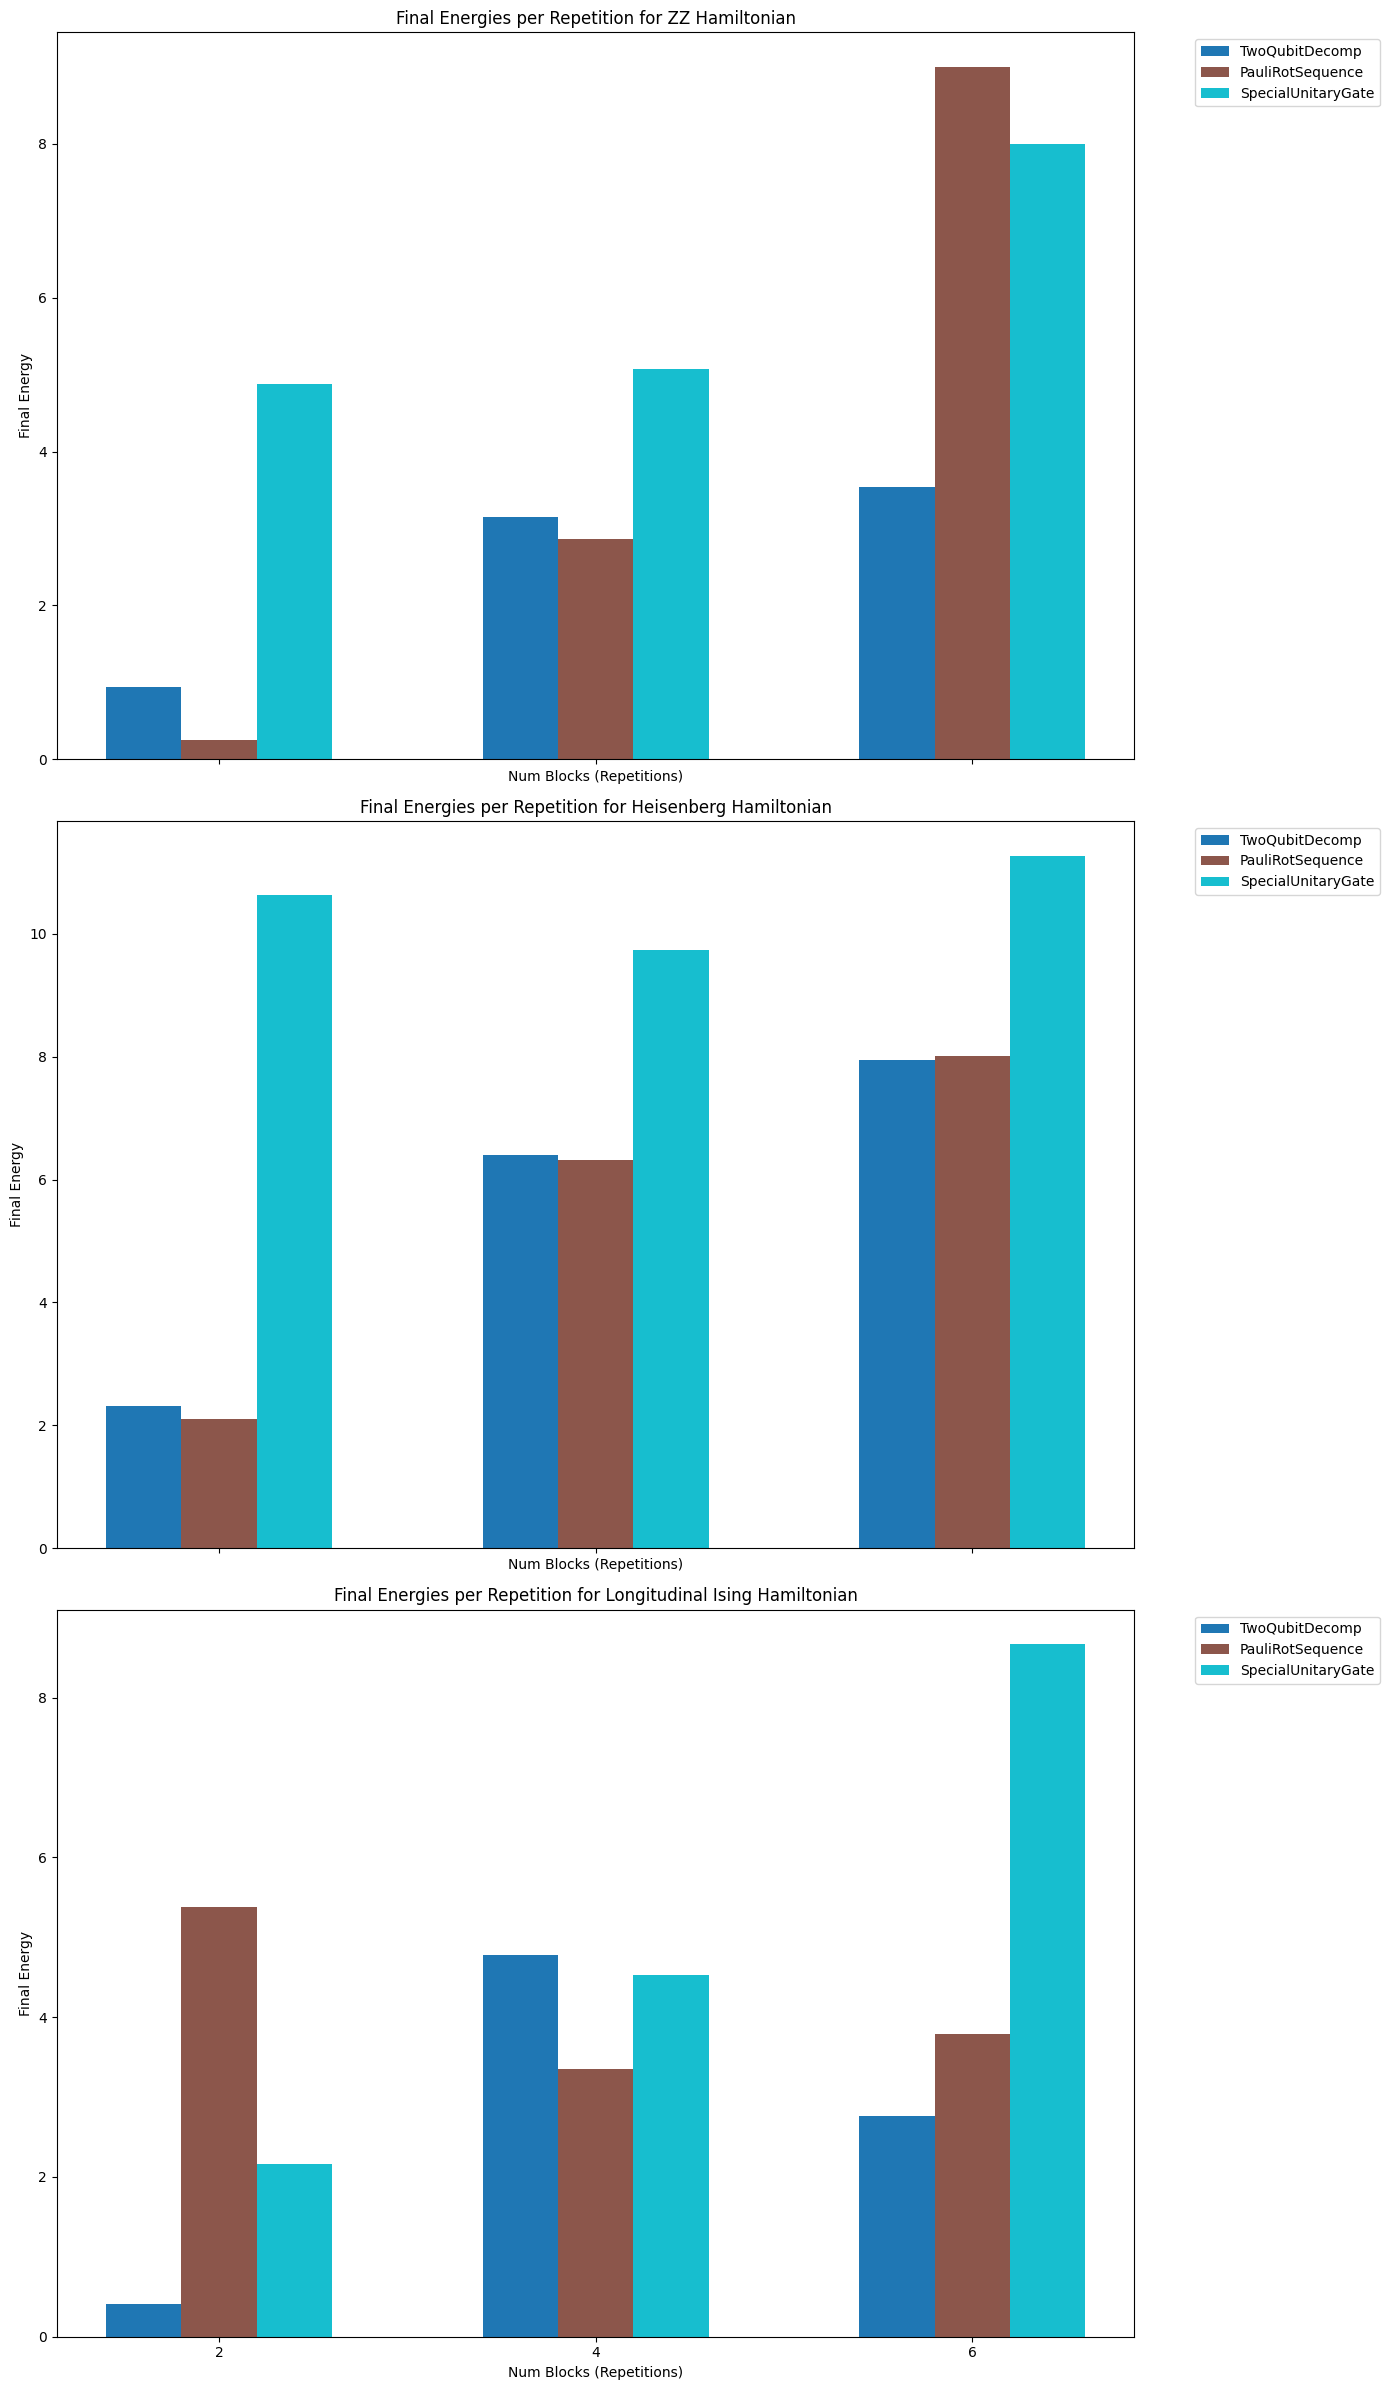

In [8]:
import matplotlib.cm as cm
# Function to plot energies vs repetitions as bar charts grouped by operations and split by Hamiltonians
def plot_energies_vs_repetitions(energies):
    hamiltonians = list(energies.keys())
    num_hamiltonians = len(hamiltonians)

    fig, axes = plt.subplots(num_hamiltonians, 1, figsize=(14, 8 * num_hamiltonians), sharex=True)

    if num_hamiltonians == 1:
        axes = [axes]

    for ax, hamiltonian in zip(axes, hamiltonians):
        operations = energies[hamiltonian]
        data = {}

        # Collect final energy data for each operation and repetition
        for operation, blocks in operations.items():
            if operation not in data:
                data[operation] = {}
            for num_blocks, values in blocks.items():
                final_energy = values[1]
                if num_blocks not in data[operation]:
                    data[operation][num_blocks] = []
                data[operation][num_blocks].append(final_energy)

        # Plotting the bar charts
        bar_width = 0.2
        num_operations = len(data)
        colors = cm.get_cmap('tab10', num_operations)
        
        repetitions = sorted({num_blocks for operation in data for num_blocks in data[operation]})
        positions = np.arange(len(repetitions))

        for idx, (operation, energies_) in enumerate(data.items()):
            final_energies = [energies_[num_block][0] for num_block in repetitions if num_block in energies_]
            print(final_energies)
            bar_positions = positions + idx * bar_width
            ax.bar(bar_positions, final_energies, bar_width, label=operation, color=colors(idx))

        ax.set_xlabel('Num Blocks (Repetitions)')
        ax.set_ylabel('Final Energy')
        ax.set_title(f'Final Energies per Repetition for {hamiltonian}')
        ax.set_xticks(positions + bar_width * (num_operations - 1) / 2)
        ax.set_xticklabels([f'{num_blocks}' for num_blocks in repetitions])
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()# Call the plot function
plot_energies_vs_repetitions(energies)


/var/folders/3j/grhshysx2qb2lnsvc18r_g0c0000gn/T/ipykernel_11224/1631713991.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(energies[next(iter(energies))]))  # Unique colors for each operation


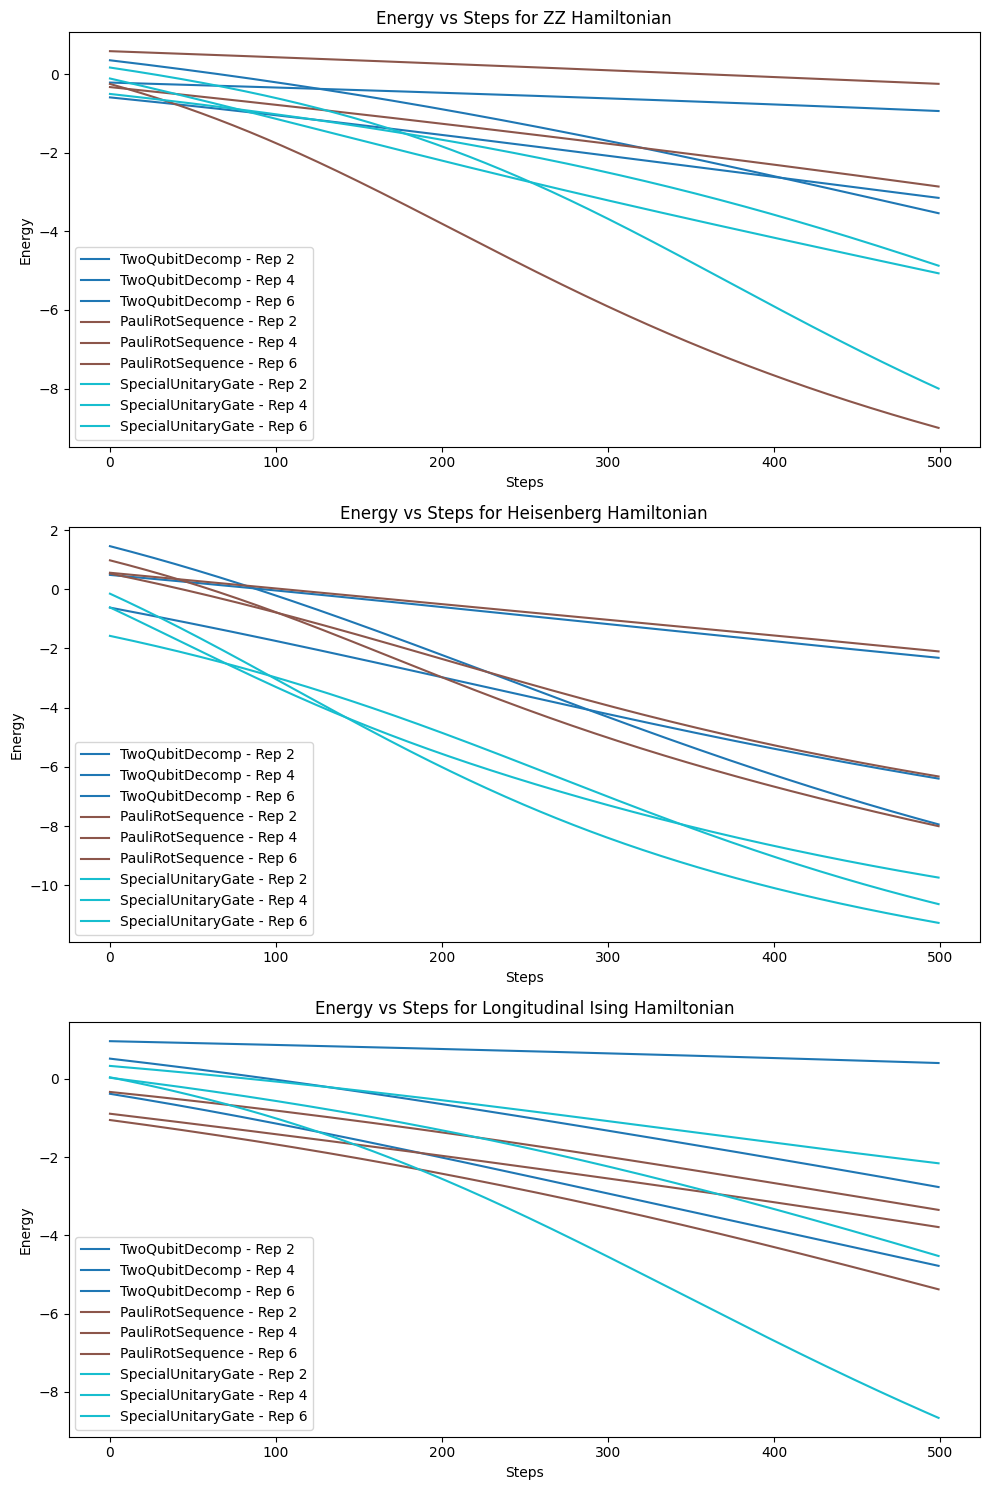

In [9]:
def plot_energy_comparison(energies):
    num_hamiltonians = len(energies)
    fig, axs = plt.subplots(num_hamiltonians, 1, figsize=(10, 5 * num_hamiltonians), squeeze=False)
    
    colors = plt.cm.get_cmap('tab10', len(energies[next(iter(energies))]))  # Unique colors for each operation

    for ax, (hamiltonian_name, operations) in zip(axs.flatten(), energies.items()):
        for i, (operation_name, repetitions) in enumerate(operations.items()):
            for repetition, values in repetitions.items():
                steps = list(range(len(values[0])))  # Steps are the index of the energy values
                energy = values[0]
                ax.plot(steps, energy, label=f"{operation_name} - Rep {repetition}", color=colors(i))
        
        ax.set_xlabel("Steps")
        ax.set_ylabel("Energy")
        ax.set_title(f"Energy vs Steps for {hamiltonian_name}")
        ax.legend()
    
    plt.tight_layout()
    plt.show()
plot_energy_comparison(energies)

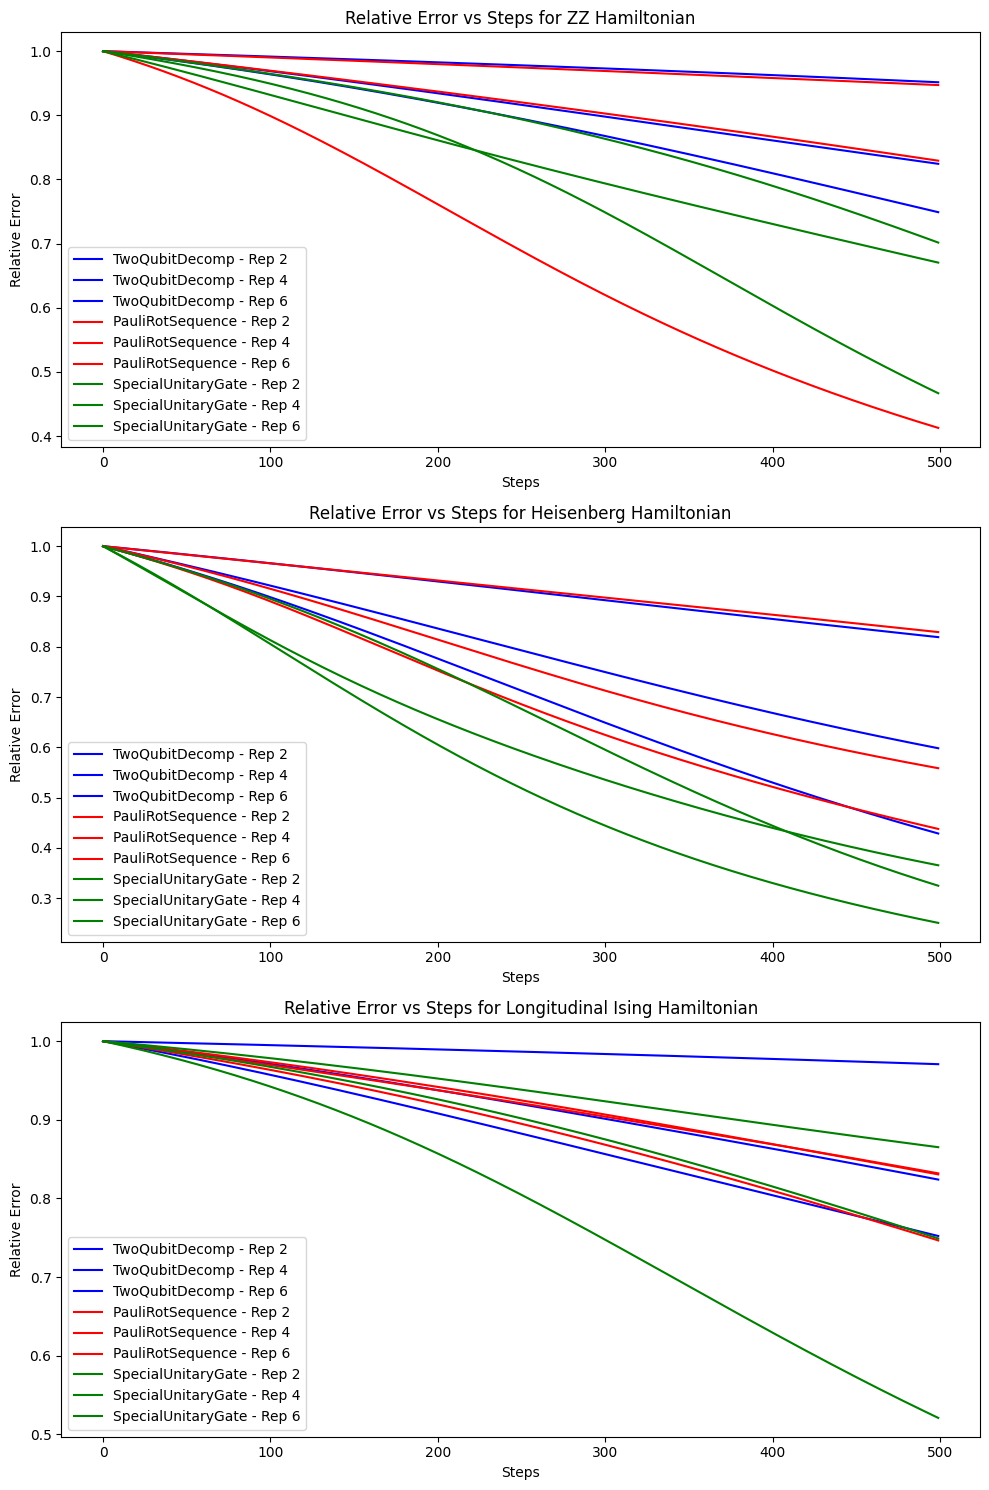

In [15]:
def plot_relative_error_comparison(energies):
    num_hamiltonians = len(energies)
    fig, axs = plt.subplots(num_hamiltonians, 1, figsize=(10, 5 * num_hamiltonians), squeeze=False)
    
    operation_colors = {'TwoQubitDecomp': 'blue', 'SpecialUnitaryGate': 'green', 'PauliRotSequence': 'red'}  # Unique colors for each operation

    for ax, (hamiltonian_name, operations) in zip(axs.flatten(), energies.items()):
        for operation_name, repetitions in operations.items():
            for repetition, values in repetitions.items():
                steps = list(range(len(values[0])))  # Steps are the index of the energy values
                energy_values = values[0]
                E_min = values[2]
                E_max = max(energy_values)
                relative_error = [(E - E_min) / (E_max - E_min) for E in energy_values]
                ax.plot(steps, relative_error, label=f"{operation_name} - Rep {repetition}", color=operation_colors[operation_name])
        
        ax.set_xlabel("Steps")
        ax.set_ylabel("Relative Error")
        ax.set_title(f"Relative Error vs Steps for {hamiltonian_name}")
        ax.legend()
    
    plt.tight_layout()
    plt.show()

plot_relative_error_comparison(energies)